In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import json
import pandas as pd
import numpy as np



<IPython.core.display.Javascript object>

In [3]:
import math

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans

<IPython.core.display.Javascript object>

In [ ]:
def get_vecs(res):
    """
    Returns two arrays, pitch vectors then timbre vectors,
    consisting of the middle 50% of the song
    """
    pitch_vecs = []
    timbre_vecs = []

    song_dur = res["track"]["duration"]
    middle_75 = (song_dur * 0.125, song_dur * (1 - 0.125))
    begin, end = middle_75
    for segment in res["segments"]:
        if begin < segment["start"] < end:
            pitch_vecs.append(segment["pitches"])
            timbre_vecs.append(segment["timbre"])

    return pitch_vecs, timbre_vecs

In [ ]:
def mean_vector_cov_1d(vectors, vec_type):

    cov_dict = {}
    if vec_type == "pitch":
        var_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    elif vec_type == "timbre":
        var_names = ["t" + str(x) for x in range(12)]

    vecs_df = pd.DataFrame(np.array(vectors), columns=var_names)
    mean_dict = dict(vecs_df.mean())

    cov_matrix = pd.DataFrame(
        np.cov(np.array(vectors).T), columns=var_names, index=var_names
    )
    tall_cov = pd.melt(cov_matrix, ignore_index=False).reset_index()
    tall_cov.columns = ["c0", "c1", "covariance"]
    # removing redundant info
    tall_cov = tall_cov[tall_cov["c0"] <= tall_cov["c1"]]
    cov_dict = {}
    for i in range(tall_cov.shape[0]):
        curr_row = tall_cov.iloc[i, :]
        c0 = curr_row["c0"]
        c1 = curr_row["c1"]
        cov = curr_row["covariance"]
        cov_dict[f"{c0}-{c1}"] = cov

    return {**mean_dict, **cov_dict}

In [4]:
song_df = pd.read_csv("../data/spotify_song_features.csv", index_col=0)

<IPython.core.display.Javascript object>

In [34]:
song_df

,id,artist,title,album,popularity,artist_ids,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1lYmMZLBWTHPybgmK00OR1,SwizZz,More to Say,More to Say,16,3nSjdp5h4cbbTOn59qKKHR,0.492,0.644,7,-7.405,1,0.5600,0.03480,0.000000,0.1230,0.425,173.440,255451,4
1,5MC3xdlx9DFop1Y4J1yDbE,Eagles,"New Kid in Town - Live at Capital Centre, Land...",Hotel California (40th Anniversary Expanded Ed...,30,0ECwFtbIWEVNwjlrfc6xoL,0.559,0.654,4,-7.977,1,0.0312,0.12600,0.000159,0.9790,0.623,110.164,292733,4
2,7GZKme55JpmLq3alBDQm11,All Time Low,Dirty Laundry,Last Young Renegade,54,46gyXjRIvN1NL1eCB8GBxo,0.560,0.751,4,-6.022,0,0.0364,0.00168,0.000052,0.1680,0.177,93.969,197640,4
3,4d2ETTRKavzvVAdo98g1T9,J.PERIOD,Thought vs. Hot 97 Freestyle - J.PERIOD Live R...,The Live Mixtape [Top 5 MC’s Edition],11,"1MGyQRNDBHqVYkW1nNKRBv, 6DJEUXZm0e2rAohdoZ5Voo...",0.623,0.928,8,-7.647,0,0.3140,0.51100,0.000002,0.7090,0.589,97.357,276292,4
4,0V9A00lULZ9ZzNslRXbvIZ,Rhys Langston,Jesus of Los Feliz,Aggressively Ethnically Ambiguous,0,"3TQniQ8z5QYYsAjrWrl72E, 5SIczlZdCyA9JdQsszygHB",0.829,0.666,5,-8.417,0,0.1100,0.73600,0.017300,0.1330,0.584,119.096,132270,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202,3ZKRGwMeoJ7aGCCKwfNNhv,Sicx,Killing Fields,If These Walls Could Talk,6,7DkekyYG58l8cuUWgAfYT7,0.606,0.541,1,-9.363,1,0.3410,0.29500,0.000014,0.1170,0.262,79.849,227213,4
7203,4Qr6D0IcHuwcDivUs3jImn,Carlo Corallo,Tornare a casa,Can'tAutorato,15,5qkSgK2UUXXa0DDBks4vqt,0.677,0.475,8,-12.073,1,0.1160,0.85600,0.000000,0.0949,0.600,95.834,200842,4
7204,3RY6QX617ECGzzsIcc57wt,SWEETBOYBLONDEY,Kein zurück,Sweet Radio Playlist,41,"5PKNAQEEXyfYEmteXrSCGI, 4PvnP3yCzrT289cX3wCdOx",0.817,0.486,5,-8.880,0,0.1270,0.17000,0.005260,0.0862,0.820,77.039,143390,4
7205,2zEy8WSuwLsQ2P8U8jSxqd,KAMACKERIS,Untouchable,Monster Mixes Vol. 1,2,4jdE12zaJk7VseMYXxZFgq,0.901,0.489,5,-12.166,0,0.4810,0.13100,0.000000,0.1850,0.707,96.540,186187,4


<IPython.core.display.Javascript object>

In [ ]:
song_ids = song_df["id"]

In [ ]:
iid = song_ids[0]

In [ ]:
iid

In [ ]:
with open(f"../data/analysis_jsons/{iid}.json") as f:
    res = json.load(f)

In [ ]:
import os

files = os.listdir("../data/analysis_jsons")

In [ ]:
files[0][:-5]

In [ ]:
song_pitches = []
song_timbres = []
for file in files:

    with open(f"../data/analysis_jsons/{file}") as f:
        res = json.load(f)
    p, t = get_vecs(res)

    pitch_cov_1d = mean_vector_cov_1d(p, "pitch")
    timbre_cov_1d = mean_vector_cov_1d(t, "timbre")

    pitch_cov_1d["id"] = file[:-5]
    timbre_cov_1d["id"] = file[:-5]

    song_pitches.append(pitch_cov_1d)
    song_timbres.append(timbre_cov_1d)

In [ ]:
pitch_cov_df = pd.DataFrame(song_pitches)
timbre_cov_df = pd.DataFrame(song_timbres)

In [ ]:
timbre_cov_df

In [ ]:
timbre_cov_df.to_csv("../data/timbre_df.csv")
pitch_cov_df.to_csv("../data/pitch_df.csv")

In [24]:
sp_info = pd.read_csv("../data/sp_info_tagged.csv", index_col=0)

<IPython.core.display.Javascript object>

In [25]:
sp_info

,artist,title,sp_title,sp_song_id,sp_artist,sp_artist_id,uuid,fm_tag,sp_tag
0,Flash Giordani,Re-Up,NaN,NaN,NaN,NaN,f4621e54-d65e-425e-866e-12560a34a0d8,alternative rap,NaN
1,Flash Giordani,Arctic Bandit,Arctic Bandit,0QE1NjeCyrAbYVVNwJDqsa,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,0e6516af-b4d0-49de-b011-19e1803b8167,alternative rap,NaN
2,Flash Giordani,She Gone 2.0,SHE GONE 2.0 ( PROD. SCOTT $AUCE),40cvs2pISPXxPdHizhD9aE,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,4b16f18a-3466-42e2-b890-93c70c98150f,alternative rap,NaN
3,Flash Giordani,Remember,Still Remember,7F0yyjJczDZ67zXbRuACyt,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,ce02634e-5f62-4359-a6a8-ded507a0fd32,alternative rap,NaN
4,Flash Giordani,Slippery Slope,NaN,NaN,NaN,NaN,bad595b9-9f18-409e-9659-769390e3d38d,alternative rap,NaN
...,...,...,...,...,...,...,...,...,...
9854,Auvie Sinclair,Tracers,Tracers,5Qrz2yiIek61N7AA3PuKlP,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,bad915ca-0279-4571-b918-d1c66b26b6f5,conscious rap,NaN
9855,Auvie Sinclair,Buzzinng,Buzzinng,2uf0MuzPOat3nem2fOL71H,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,f5111595-bcb9-4b8a-a468-749aa9304f93,conscious rap,NaN
9856,Auvie Sinclair,Golden! (feat. Chi Chi),NaN,NaN,NaN,NaN,ea3d6202-156e-436e-a6e4-fde25c0b0b78,conscious rap,NaN
9857,Auvie Sinclair,Shine,Shine,5jSU23HHpQHveXlOUu4tGc,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,119aa87c-3c80-4bf8-afa4-23abbf937eec,conscious rap,NaN


<IPython.core.display.Javascript object>

In [6]:
timbre_cov_df = pd.read_csv("../data/timbre_df.csv", index_col=0)

<IPython.core.display.Javascript object>

In [7]:
timbre_cov_df = timbre_cov_df.set_index("id")

<IPython.core.display.Javascript object>

In [26]:
song_df["fm_tag"] = None


<IPython.core.display.Javascript object>

In [27]:
timbre_cov_df["fm_tag"] = None

<IPython.core.display.Javascript object>

In [28]:
for i in range(song_df.shape[0]):
    s_id = song_df.loc[i, "id"]
    fm_tag = sp_info[sp_info["sp_song_id"] == s_id]["fm_tag"].values[0]
    song_df.loc[i, "fm_tag"] = fm_tag
    if s_id in timbre_cov_df.index:
        timbre_cov_df.loc[s_id, "fm_tag"] = fm_tag

<IPython.core.display.Javascript object>

In [29]:
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["West coast rap", "hyphy"]), "fm_tag"
] = "west coast"
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["East coast rap", "boom bap"]), "fm_tag"
] = "east coast"
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["southern rap", "crunk"]), "fm_tag"
] = "southern"

<IPython.core.display.Javascript object>

In [30]:
X = timbre_cov_df.drop("fm_tag", 1)
y = timbre_cov_df["fm_tag"]
drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]

X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [31]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [85]:
timbre_cov_df.dropna()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,fm_tag
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,51.823612,20.298719,-7.290977,-11.141729,27.893418,-17.370409,2.325935,-5.247523,7.916673,1.860364,...,-9.255381,12.455460,-3.977513,-48.312000,261.299412,-7.627733,-75.358357,-16.209842,174.110043,conscious rap
1MSY5BfSg3wmtUFmtSBjs5,42.902985,57.353380,-8.897260,0.845510,34.859784,-18.322556,-10.257845,2.666678,-3.077387,6.007564,...,-35.039057,0.690710,2.864370,78.139559,289.719916,-5.924260,57.640365,-25.937092,187.967932,gangsta rap
073YMUpCNOSQjh5Mdr3H4A,51.320322,21.978182,21.876141,9.708738,21.285144,-13.235833,10.511639,8.868929,-14.419142,1.017309,...,-12.405163,9.488410,-3.525158,-31.851975,246.398071,-9.402846,15.085525,-17.672299,179.191567,conscious rap
6k4PmS9TcDQiEapSZkkcWB,47.247010,11.126041,-23.075194,-13.589925,44.776245,-16.985980,-12.936440,-10.717618,-11.349298,0.989104,...,-38.364132,46.119521,1.786425,-93.227843,321.643500,-2.372743,22.555682,-29.756121,222.617446,conscious rap
1AGjfwW4QoWFfhp1IA6wcE,47.404934,34.067367,-8.539390,-11.257607,37.728593,-14.631699,-4.338456,0.631410,-6.794711,7.955006,...,-51.221066,23.881200,-3.873569,-64.942901,279.560282,-13.661741,-123.210046,-37.850406,226.895772,conscious rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7lvwYGIi8ZVqvTtEAqRwwp,47.994236,39.793230,-33.009235,0.124890,5.957860,-12.930415,5.685226,-0.405510,-2.671963,5.281936,...,-0.688365,6.679347,-1.079003,136.515154,505.659839,-4.422433,-147.176910,-16.830454,230.094193,alternative rap
4MrfYtNMl169SWUH8cJBli,49.905521,3.800089,4.192998,1.451093,22.359075,-19.951405,7.122938,-0.245278,-9.628937,-1.527966,...,-11.740445,3.405882,-0.460251,25.870257,309.655921,-1.672027,0.970392,-13.616583,198.535574,west coast
06R3hA4D1jyj8f8untfQNB,50.046513,70.963756,-45.772269,-14.639832,17.559342,6.202878,-8.205195,-5.404654,-8.536383,6.549886,...,2.253407,28.027996,9.754956,180.952252,738.632347,-6.092132,119.278371,-111.629820,251.024735,trap


<IPython.core.display.Javascript object>

In [65]:
X

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t7-t9,t8-t9,t10-t9,t11-t9,t0-t10,t1-t10,t0-t11,t1-t11,t10-t11,t11-t11
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,51.823612,20.298719,-7.290977,-11.141729,27.893418,-17.370409,2.325935,-5.247523,7.916673,1.860364,...,-121.572511,-43.605135,-9.255381,12.455460,-3.977513,-48.312000,-7.627733,-75.358357,-16.209842,174.110043
1MSY5BfSg3wmtUFmtSBjs5,42.902985,57.353380,-8.897260,0.845510,34.859784,-18.322556,-10.257845,2.666678,-3.077387,6.007564,...,-95.427052,-9.551972,-35.039057,0.690710,2.864370,78.139559,-5.924260,57.640365,-25.937092,187.967932
073YMUpCNOSQjh5Mdr3H4A,51.320322,21.978182,21.876141,9.708738,21.285144,-13.235833,10.511639,8.868929,-14.419142,1.017309,...,-69.477335,11.180422,-12.405163,9.488410,-3.525158,-31.851975,-9.402846,15.085525,-17.672299,179.191567
6k4PmS9TcDQiEapSZkkcWB,47.247010,11.126041,-23.075194,-13.589925,44.776245,-16.985980,-12.936440,-10.717618,-11.349298,0.989104,...,-260.097820,-158.014813,-38.364132,46.119521,1.786425,-93.227843,-2.372743,22.555682,-29.756121,222.617446
1AGjfwW4QoWFfhp1IA6wcE,47.404934,34.067367,-8.539390,-11.257607,37.728593,-14.631699,-4.338456,0.631410,-6.794711,7.955006,...,-138.889952,-109.893743,-51.221066,23.881200,-3.873569,-64.942901,-13.661741,-123.210046,-37.850406,226.895772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5bDv490EvT3CR6mfF78xL5,44.763783,76.052035,-23.341510,-11.778465,19.383785,-5.344268,8.010707,9.105040,-20.509906,12.718325,...,-312.529060,-106.671392,-49.886646,51.005932,5.100442,81.684350,-17.092134,-12.106612,-92.024391,256.953795
2ada2pkDF8JKXlrhJLxzV8,51.636761,49.987225,-8.736434,-18.482447,24.550814,-34.695512,-0.372974,6.119248,-2.831585,2.180300,...,-47.134695,-7.366050,-10.770460,10.104666,4.061721,-45.077901,-3.142690,57.088009,-5.135911,190.890822
1xYpVRspgaLxdJLOTQkTjg,48.266011,44.672432,-46.425752,-17.552224,48.055761,-27.178167,-8.145469,-7.243402,-10.502099,0.823474,...,-269.227102,-111.912231,-32.514908,12.305223,10.714995,46.534939,5.512230,156.628291,-17.914056,250.235187


<IPython.core.display.Javascript object>

In [24]:
# putting together hover information for plotly data later
# none of this is being used for umap/clustering

desc_cols = [
    "artist",
    "title",
    "popularity",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "fm_tag",
]

px_num = song_df[desc_cols].select_dtypes("number")
px_cat = song_df[desc_cols].select_dtypes("O")

minmax_scaler = MinMaxScaler()
scaled_num = pd.DataFrame(minmax_scaler.fit_transform(px_num), columns=px_num.columns)
px_df = pd.concat([scaled_num, px_cat], 1)
px_df = px_df.round(1)

<IPython.core.display.Javascript object>

In [32]:
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])


<IPython.core.display.Javascript object>

/home/b1t/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='c0', ylabel='c1'>

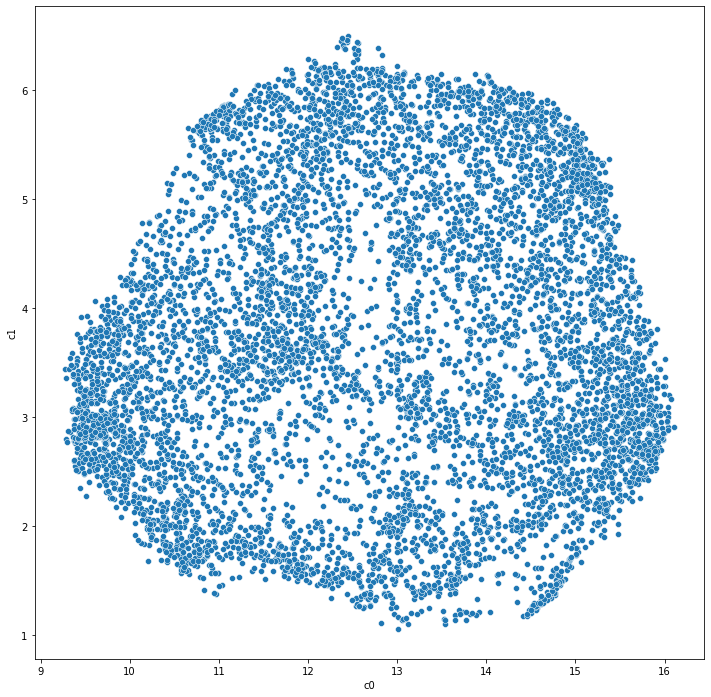

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", data=umap_df)

In [114]:
y

id
1oK6IuZqBqljKHS3bFNUg7      conscious rap
1MSY5BfSg3wmtUFmtSBjs5        gangsta rap
073YMUpCNOSQjh5Mdr3H4A      conscious rap
6k4PmS9TcDQiEapSZkkcWB      conscious rap
1AGjfwW4QoWFfhp1IA6wcE      conscious rap
                               ...       
7lvwYGIi8ZVqvTtEAqRwwp    alternative rap
4MrfYtNMl169SWUH8cJBli         west coast
06R3hA4D1jyj8f8untfQNB               trap
1IXFUiox0g7GZMd0qfVrWF        gangsta rap
5bDv490EvT3CR6mfF78xL5               trap
Name: fm_tag, Length: 4445, dtype: object

<IPython.core.display.Javascript object>

In [16]:
umap_df["fm_tag"] = y.values

<IPython.core.display.Javascript object>

In [17]:
umap_df

,c0,c1,fm_tag
0,15.266953,2.777171,conscious rap
1,16.001177,3.287790,gangsta rap
2,15.121014,3.286619,conscious rap
3,13.855649,3.297571,conscious rap
4,15.002456,5.632891,conscious rap
...,...,...,...
7201,12.916439,5.229949,gangsta rap
7202,12.113448,5.632013,trap
7203,15.529025,2.693091,NaN
7204,10.546054,2.329974,NaN


<IPython.core.display.Javascript object>

/home/b1t/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='c0', ylabel='c1'>

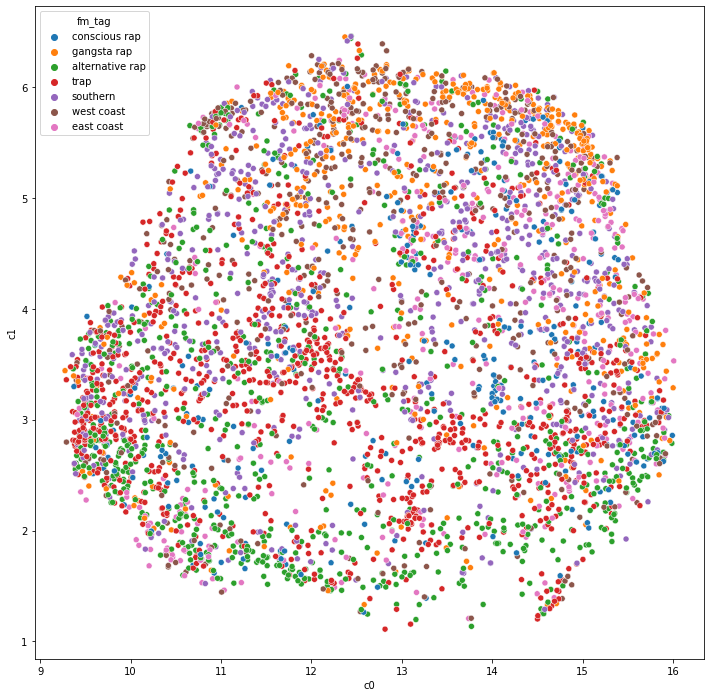

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", data=umap_df, hue="fm_tag")

In [34]:
song_df["fm_tag"].value_counts()

trap               1112
alternative rap    1106
southern rap        817
West coast rap      606
gangsta rap         567
boom bap            421
crunk               299
conscious rap       298
East coast rap      275
hyphy               188
Name: fm_tag, dtype: int64

<IPython.core.display.Javascript object>

In [42]:
song_df.loc[
    song_df["fm_tag"].isin(["West coast rap", "hyphy"]), "fm_tag"
] = "west coast"

<IPython.core.display.Javascript object>

In [44]:
song_df.loc[
    song_df["fm_tag"].isin(["East coast rap", "boom bap"]), "fm_tag"
] = "east coast"

<IPython.core.display.Javascript object>

In [46]:
song_df.loc[song_df["fm_tag"].isin(["southern rap", "crunk"]), "fm_tag"] = "southern"

<IPython.core.display.Javascript object>

In [77]:
umap_df.loc[
    umap_df["fm_tag"].isin(["West coast rap", "hyphy"]), "fm_tag"
] = "west coast"
umap_df.loc[
    umap_df["fm_tag"].isin(["East coast rap", "boom bap"]), "fm_tag"
] = "east coast"
umap_df.loc[umap_df["fm_tag"].isin(["southern rap", "crunk"]), "fm_tag"] = "southern"

<IPython.core.display.Javascript object>

In [117]:
sp_info

,artist,title,sp_title,sp_song_id,sp_artist,sp_artist_id,uuid,fm_tag
0,Flash Giordani,Re-Up,NaN,NaN,NaN,NaN,f4621e54-d65e-425e-866e-12560a34a0d8,alternative rap
1,Flash Giordani,Arctic Bandit,Arctic Bandit,0QE1NjeCyrAbYVVNwJDqsa,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,0e6516af-b4d0-49de-b011-19e1803b8167,alternative rap
2,Flash Giordani,She Gone 2.0,SHE GONE 2.0 ( PROD. SCOTT $AUCE),40cvs2pISPXxPdHizhD9aE,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,4b16f18a-3466-42e2-b890-93c70c98150f,alternative rap
3,Flash Giordani,Remember,Still Remember,7F0yyjJczDZ67zXbRuACyt,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,ce02634e-5f62-4359-a6a8-ded507a0fd32,alternative rap
4,Flash Giordani,Slippery Slope,NaN,NaN,NaN,NaN,bad595b9-9f18-409e-9659-769390e3d38d,alternative rap
...,...,...,...,...,...,...,...,...
9854,Auvie Sinclair,Tracers,Tracers,5Qrz2yiIek61N7AA3PuKlP,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,bad915ca-0279-4571-b918-d1c66b26b6f5,conscious rap
9855,Auvie Sinclair,Buzzinng,Buzzinng,2uf0MuzPOat3nem2fOL71H,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,f5111595-bcb9-4b8a-a468-749aa9304f93,conscious rap
9856,Auvie Sinclair,Golden! (feat. Chi Chi),NaN,NaN,NaN,NaN,ea3d6202-156e-436e-a6e4-fde25c0b0b78,conscious rap
9857,Auvie Sinclair,Shine,Shine,5jSU23HHpQHveXlOUu4tGc,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,119aa87c-3c80-4bf8-afa4-23abbf937eec,conscious rap


<IPython.core.display.Javascript object>

In [55]:
lyrics_df = pd.Series(index=X.index)

<ipython-input-55-76a1853871e2>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lyrics_df = pd.Series(index=X.index)


<IPython.core.display.Javascript object>

In [56]:
lyrics_df

id
1oK6IuZqBqljKHS3bFNUg7   NaN
1MSY5BfSg3wmtUFmtSBjs5   NaN
073YMUpCNOSQjh5Mdr3H4A   NaN
6k4PmS9TcDQiEapSZkkcWB   NaN
1AGjfwW4QoWFfhp1IA6wcE   NaN
                          ..
1IXFUiox0g7GZMd0qfVrWF   NaN
5bDv490EvT3CR6mfF78xL5   NaN
2ada2pkDF8JKXlrhJLxzV8   NaN
1xYpVRspgaLxdJLOTQkTjg   NaN
2GNco2zPVEdgkC85SESXl3   NaN
Length: 7206, dtype: float64

<IPython.core.display.Javascript object>

In [57]:
for s_id in X.index[:]:
    obs = sp_info.loc[sp_info["sp_song_id"] == s_id, :]
    s_artist = obs["artist"].values[0]
    s_title = obs["title"].values[0]
    with open(f"../data/song_lyrics/{s_artist}/{s_title}.txt", "r") as f:
        lyrics = "".join([line for line in f])
    lyrics_df.loc[s_id] = lyrics
#     print(lyrics)
#     print(s_id)

<IPython.core.display.Javascript object>

In [77]:
lyrics_df.isna().sum()

original       0
cleaned     7206
lang           0
dtype: int64

<IPython.core.display.Javascript object>

In [61]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

<IPython.core.display.Javascript object>

In [1]:
def preprocess(doc):
    stemmer = SnowballStemmer("english")
    doc = doc.replace("\n", " ")
    tokenized = word_tokenize(doc)

    cleaned = [
        stemmer.stem(token.lower())
        for token in tokenized
        if not token.lower() in stopwords.words("english")
        if token.isalpha()
    ]
    untokenized = " ".join(cleaned)
    return untokenized

In [151]:
d = lyrics_df.iloc[0, 0]
print(preprocess(d))

puff puff pass circl boy roll weed zig zag lightin tree like forest fire smokey bear preacher tri talk ai realli tryin hear mix littl teenag angst ignor everi chang get ya know kid get belliger caus though know better world unprepar caus peer pressur strong never cool care consequ flash forward year stori done chang see littl growin crazi perspect chang head knee bathroom throwin still took fatal accident overdos circl wake time get fabric life delic get mani chanc thank never fulli rip rememb back cool gettin troubl never follow rule nowaday thing chang everytim tri talk tryin get blunt rememb back cool gettin troubl never follow rule nowaday thing chang everytim tri talk tryin get blunt rememb back kid would chill talk life wan na live momma crib memori take back man nowaday hard tell man look eye alway look distant there empti insid em mind indiffer mind peopl around say dumb world that full pain easier stay numb start drink graduat weed pop anoth pill pourin lean say homi realli bu

<IPython.core.display.Javascript object>

In [63]:
lyrics_df = pd.DataFrame(lyrics_df)
lyrics_df.columns = ["original"]
lyrics_df["cleaned"] = None
lyrics_df

,original,cleaned
id,,
1oK6IuZqBqljKHS3bFNUg7,Puff puff pass and I'm in that\nCircle with my...,None
1MSY5BfSg3wmtUFmtSBjs5,"Yo, what's happenin Cold 187\nYo man, you know...",None
073YMUpCNOSQjh5Mdr3H4A,Normalerweise kommt man so nicht in Clubs\nIch...,None
6k4PmS9TcDQiEapSZkkcWB,Parlo da solo stanotte che chi mi ascolterebbe...,None
1AGjfwW4QoWFfhp1IA6wcE,"Yeah man, ever since I was a kid like\nPeople ...",None
...,...,...
1IXFUiox0g7GZMd0qfVrWF,"L.T., Uh, The nerve of this bitch\n\nA bitch m...",None
5bDv490EvT3CR6mfF78xL5,In the kitchen whipping up the cocaina\nPull u...,None
2ada2pkDF8JKXlrhJLxzV8,I haven't been sober in a week or more\nAnd my...,None


<IPython.core.display.Javascript object>

In [64]:
import fasttext

PRETRAINED_MODEL_PATH = "/tmp/lid.176.bin"
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

<IPython.core.display.Javascript object>

In [66]:
lyrics_df["lang"] = None
for i in range(lyrics_df.shape[0]):
    s = lyrics_df.iloc[i, 0].replace("\n", " ")
    prediction = model.predict(s)
    lyrics_df.iloc[i, 2] = prediction[0][0].replace("__label__", "")

<IPython.core.display.Javascript object>

In [70]:
english_lyrics = lyrics_df[lyrics_df["lang"] == "en"]

<IPython.core.display.Javascript object>

In [78]:
english_lyrics.isna().sum()

original    0
cleaned     0
lang        0
dtype: int64

<IPython.core.display.Javascript object>

In [72]:
for i in range(lyrics_df.shape[0]):
    english_lyrics.iloc[i, 1] = preprocess(english_lyrics.iloc[i, 0])

/home/b1t/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-72-3c2174f1c69e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_lyrics.iloc[i, 1] = preprocess(english_lyrics.iloc[i, 0])


IndexError: single positional indexer is out-of-bounds

<IPython.core.display.Javascript object>

In [80]:
english_lyrics[english_lyrics["cleaned"].isna()]

,original,cleaned,lang
id,,,


<IPython.core.display.Javascript object>

In [83]:
english_lyrics["original"].value_counts()[:20]

          \n            Lyrics for this song have yet to be released. Please check back once the song has been released.\n          \n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

<IPython.core.display.Javascript object>

In [87]:
english_lyrics[
    english_lyrics["original"]
    == "\nLyrics for this song have yet to be released. Please check back once the song has been released.\n\n"
]

,original,cleaned,lang
id,,,


<IPython.core.display.Javascript object>

In [54]:
lyrics_df

,original,cleaned,lang
id,,,
1oK6IuZqBqljKHS3bFNUg7,Puff puff pass and I'm in that\nCircle with my...,puff puff pass circl boy roll weed zig zag lig...,en
1MSY5BfSg3wmtUFmtSBjs5,"Yo, what's happenin Cold 187\nYo man, you know...",yo happenin cold yo man know laid back studio ...,en
073YMUpCNOSQjh5Mdr3H4A,Normalerweise kommt man so nicht in Clubs\nIch...,normalerweis kommt man nicht club ich bin nich...,de
6k4PmS9TcDQiEapSZkkcWB,Parlo da solo stanotte che chi mi ascolterebbe...,parlo da solo stanott che chi mi ascolterebb d...,it
1AGjfwW4QoWFfhp1IA6wcE,"Yeah man, ever since I was a kid like\nPeople ...",yeah man ever sinc kid like peopl would ask fa...,en
...,...,...,...
1IXFUiox0g7GZMd0qfVrWF,"L.T., Uh, The nerve of this bitch\n\nA bitch m...",uh nerv bitch bitch main purpos servic mac ski...,en
5bDv490EvT3CR6mfF78xL5,In the kitchen whipping up the cocaina\nPull u...,kitchen whip cocaina pull chick vroom vroom se...,en
2ada2pkDF8JKXlrhJLxzV8,I haven't been sober in a week or more\nAnd my...,sober week card got declin liquor store spent ...,en


<IPython.core.display.Javascript object>

In [45]:
import fasttext

PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)


<IPython.core.display.Javascript object>

In [47]:
lyrics_df["lang"] = None

<IPython.core.display.Javascript object>

In [52]:
lyrics_df.to_csv("../data/lyrics.csv")

<IPython.core.display.Javascript object>

In [48]:
for i in range(lyrics_df.shape[0]):
    s = lyrics_df.iloc[i, 1]
    prediction = model.predict(s)
    lyrics_df.iloc[i, 2] = prediction[0][0].replace("__label__", "")

<IPython.core.display.Javascript object>

In [53]:
lyrics_df.isna()

,original,cleaned,lang
id,,,
1oK6IuZqBqljKHS3bFNUg7,False,False,False
1MSY5BfSg3wmtUFmtSBjs5,False,False,False
073YMUpCNOSQjh5Mdr3H4A,False,False,False
6k4PmS9TcDQiEapSZkkcWB,False,False,False
1AGjfwW4QoWFfhp1IA6wcE,False,False,False
...,...,...,...
1IXFUiox0g7GZMd0qfVrWF,False,False,False
5bDv490EvT3CR6mfF78xL5,False,False,False
2ada2pkDF8JKXlrhJLxzV8,False,False,False


<IPython.core.display.Javascript object>

In [20]:
lyrics_df = pd.read_csv("../data/lyrics.csv")

<IPython.core.display.Javascript object>

In [50]:
english_lyrics = lyrics_df[lyrics_df["lang"] == "en"]

<IPython.core.display.Javascript object>

In [51]:
english_lyrics

,original,cleaned,lang
id,,,
1oK6IuZqBqljKHS3bFNUg7,Puff puff pass and I'm in that\nCircle with my...,puff puff pass circl boy roll weed zig zag lig...,en
1MSY5BfSg3wmtUFmtSBjs5,"Yo, what's happenin Cold 187\nYo man, you know...",yo happenin cold yo man know laid back studio ...,en
1AGjfwW4QoWFfhp1IA6wcE,"Yeah man, ever since I was a kid like\nPeople ...",yeah man ever sinc kid like peopl would ask fa...,en
0FRENAN5snwnoRVJ6eDuFm,You coulda been mine but\nYou coulda been mine...,coulda mine coulda mine coulda mine put line c...,en
3BUWNzPWz2mDbptZmGEXpB,"Let it all work out, let it all work out\nLet ...",let work let work let work let work let work l...,en
...,...,...,...
06R3hA4D1jyj8f8untfQNB,Th-th-th-think we found a loophole\nA hunnid s...,found loophol hunnid shotta two oppa bet glock...,en
1IXFUiox0g7GZMd0qfVrWF,"L.T., Uh, The nerve of this bitch\n\nA bitch m...",uh nerv bitch bitch main purpos servic mac ski...,en
5bDv490EvT3CR6mfF78xL5,In the kitchen whipping up the cocaina\nPull u...,kitchen whip cocaina pull chick vroom vroom se...,en


<IPython.core.display.Javascript object>

In [22]:
tfidf = TfidfVectorizer(min_df=2)
vectorized = tfidf.fit_transform(english_lyrics["cleaned"])

NameError: name 'TfidfVectorizer' is not defined

<IPython.core.display.Javascript object>

In [177]:
tfidf_df = pd.DataFrame(
    vectorized.toarray(), columns=tfidf.get_feature_names(), index=english_lyrics.index
)

<IPython.core.display.Javascript object>

In [180]:
tfidf_df

,aa,aah,aahh,aaliyah,aaron,ab,abacus,abandon,abbi,abc,...,zoo,zoogang,zoom,zoot,zoovi,zoovier,zoowap,zora,zulu,ńemi
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1MSY5BfSg3wmtUFmtSBjs5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1AGjfwW4QoWFfhp1IA6wcE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0FRENAN5snwnoRVJ6eDuFm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39UBPbii4mLlSz5mWcmWh4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5IbMqEWUanwZU4g6iNmSTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4MrfYtNMl169SWUH8cJBli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06R3hA4D1jyj8f8untfQNB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [181]:
tagged = timbre_cov_df.dropna()
# X = tagged.drop("fm_tag", 1)
X = tfidf_df
y = tagged.loc[english_lyrics.index, "fm_tag"]
# drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]

# X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [182]:
from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=34
)

<IPython.core.display.Javascript object>

In [184]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [98]:
from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [185]:
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
model.score(X_test, y_test)

In [105]:
from sklearn.neighbors import KNeighborsClassifier

<IPython.core.display.Javascript object>

In [188]:
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1, weights="distance")

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.24273255813953487

<IPython.core.display.Javascript object>

In [104]:
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [ ]:
params={'max_depth':[3,4,5],
       }
model_cv =